In [1]:
# 1. Reading data
import tensorflow as tf
import tensorflow_hub as hub
import sklearn
import tensorflow_text as text
import pandas as pd

# Data Read and Display
df = pd.read_csv("spam_ham_dataset.csv")
df_grouped = df.groupby('Category')
print(df_grouped['Category'].value_counts())
# ham       ham         3672
# spam      spam        1499

2024-04-20 00:42:35.517014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 00:42:35.517054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 00:42:35.517723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-20 00:42:35.521561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 00:42:36.044721: W tensorflow/compiler/tf2

Category
ham     3672
spam    1499
Name: count, dtype: int64


In [2]:
# 2. Dealing with Unbalanced Data
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_balanced = pd.concat([df_ham_downsampled, df_spam])
print(df_balanced.shape)
print(df_balanced['Category'].value_counts())

(2998, 2)
Category
ham     1499
spam    1499
Name: count, dtype: int64


In [3]:
# 3. Preparing Data
#Converting catagory to Numeric
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
print(df_balanced.sample(5))

# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

     Category                                            Message  spam
3748     spam  Subject: hi paliourg get all pills . everythin...     1
2703     spam  Subject: [ wrenches ] 68 % off dreamweaver mx ...     1
1517     spam  Subject: keep your memories alive with a free ...     1
2774      ham  Subject: duns number changes\r\nfyi\r\n- - - -...     0
1048      ham  Subject: potential list for april , 2000\r\nth...     0


In [4]:
# 4. Get BERT base sentence embeddings
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

2024-04-20 00:42:37.230970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2024-04-20 00:42:43.439068: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132726 , -0.88845736, ..., -0.7474886 ,
        -0.75314736,  0.91964483],
       [-0.8720836 , -0.50543964, -0.94446677, ..., -0.858475  ,
        -0.7174535 ,  0.8808298 ]], dtype=float32)>

In [5]:
# 6. Test Sentence Embeddings
# Get embeding vectors for few sample words. Compare them using cosine similarity
e = get_sentence_embeding(["banana","grapes","mango","jeff bezos","elon musk",
    "bill gates"])
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity([e[0]],[e[1]]))
print(cosine_similarity([e[0]],[e[3]]))
print(cosine_similarity([e[3]],[e[4]]))
# Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above
print(cosine_similarity([e[3]],[e[4]]))

[[0.9911089]]
[[0.84703803]]
[[0.9872033]]
[[0.9872033]]


In [6]:
# 7. Build Model
#  Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
print(model.summary())
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [7]:
# 8. Train and Evaluate 
model.fit(X_train, y_train, epochs=10)
model.evaluate(X_test, y_test)

y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
print(y_predicted)

Epoch 1/10
 1/71 [..............................] - ETA: 5:28 - loss: 0.8584 - accuracy: 0.4375 - precision: 0.4074 - recall: 0.8462

2024-04-20 00:44:48.012046: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2560158380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-20 00:44:48.012074: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-04-20 00:44:48.015648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-20 00:44:48.038615: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
I0000 00:00:1713566688.098170   22875 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 [==============================] - 17s 179ms/step - loss: 0.6603 - accuracy: 0.5867 - precision: 0.5889 - recall: 0.5747
Epoch 2/10
71/71 [==============================] - 13s 180ms/step - loss: 0.5723 - accuracy: 0.7046 - precision: 0.7114 - recall: 0.6886
Epoch 3/10
71/71 [==============================] - 13s 179ms/step - loss: 0.5260 - accuracy: 0.7389 - precision: 0.7399 - recall: 0.7367
Epoch 4/10
71/71 [==============================] - 13s 181ms/step - loss: 0.4980 - accuracy: 0.7709 - precision: 0.7721 - recall: 0.7687
Epoch 5/10
71/71 [==============================] - 13s 182ms/step - loss: 0.4580 - accuracy: 0.8074 - precision: 0.8110 - recall: 0.8016
Epoch 6/10
71/71 [==============================] - 13s 183ms/step - loss: 0.4388 - accuracy: 0.8234 - precision: 0.8308 - recall: 0.8123
Epoch 7/10
71/71 [==============================] - 13s 185ms/step - loss: 0.4156 - accuracy: 0.8350 - precision: 0.8329 - recall: 0.8381
Epoch 8/10
71/71 [===========================

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       375
           1       0.94      0.79      0.86       375

    accuracy                           0.87       750
   macro avg       0.88      0.87      0.87       750
weighted avg       0.88      0.87      0.87       750



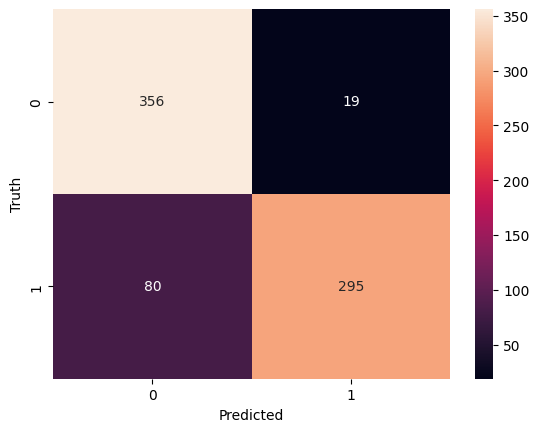

In [9]:
# 9. Display Results
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, y_predicted))

In [12]:
# 10. Inference
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 0s 28ms/step


array([[0.49204704],
       [0.44072098],
       [0.37721717],
       [0.68176264],
       [0.8307592 ]], dtype=float32)